# Hamiltonian energy level shuffling demo

In [1]:
import numpy as np
from scipy.linalg import expm
import lindbladian_sim as lbs
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng(42)

## Construct a random Hamiltonian

In [3]:
# system size
d = 40

In [4]:
# random Hamiltonian
H = lbs.crandn((d, d), rng)
H = 0.5 * (H + H.conj().T)

In [5]:
eigvals, eigvec = np.linalg.eigh(H)

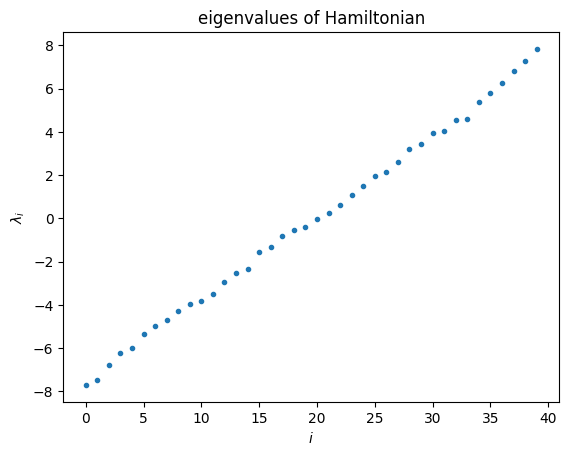

In [6]:
plt.plot(eigvals, '.')
plt.xlabel(r"$i$")
plt.ylabel(r"$\lambda_i$")
plt.title("eigenvalues of Hamiltonian")
plt.show()

In [7]:
# spectral gap
gap = eigvals[1] - eigvals[0]
print("eigenvalue gap:", gap)

eigenvalue gap: 0.2480333447726073


## Filter function

In [8]:
# spectral width
Sw = np.linalg.norm(H, ord=2)
Sw

7.834562242804822

In [9]:
# parameters for filter function
a  = 2.5*Sw
da = 0.5*Sw
b  = gap
db = gap

fhat = lambda w: lbs.filter_function(w, a, da, b, db)

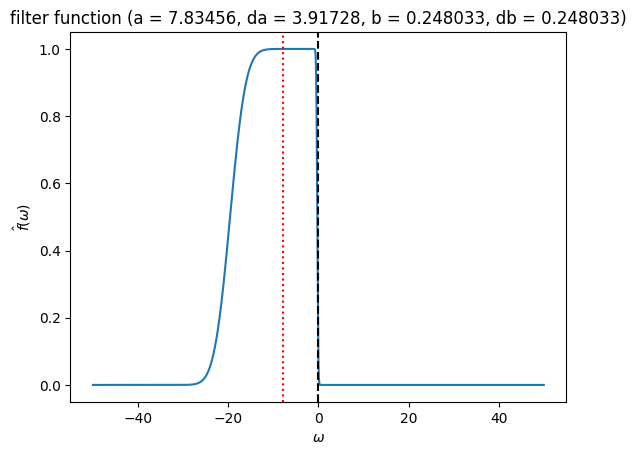

In [10]:
# visualize filter function
wlist = np.linspace(-50, 50, 1001, endpoint=True)
plt.plot(wlist, fhat(wlist))
plt.xlabel(r"$\omega$")
plt.ylabel(r"$\hat{f}(\omega)$")
plt.title(f"filter function (a = {Sw:g}, da = {da:g}, b = {b:g}, db = {db:g})")
plt.axvline(0, color="k", linestyle="--")
plt.axvline(-Sw, color="r", linestyle=":")
plt.show()

## Construct Lindbladian operator

In [11]:
# "sparse" local operator
A = np.kron(lbs.crandn((d//5, d//5), rng), np.identity(5))

In [12]:
# shuffling Lindblad jump operator
K = lbs.construct_shuffling_lindblad_operator(A, H, fhat)
K.shape

(40, 40)

In [13]:
# time step
tau = 0.1

## Simulate dissipative time evolution

In [14]:
# time evolution operator (superoperator representation), including coherent Hamiltonian part
expHK = expm(tau * (lbs.hamiltonian_superoperator(H) + lbs.lindblad_operator_matrix(K)))
expHK.shape

(1600, 1600)

In [15]:
rho_init = lbs.random_density_matrix(d, rng)

In [16]:
nsteps = 2000

rho = rho_init
en_list = [np.trace(H @ rho).real]
for n in range(nsteps):
    rho = np.reshape(expHK @ rho.reshape(-1), rho.shape)
    en_list.append(np.trace(H @ rho).real)

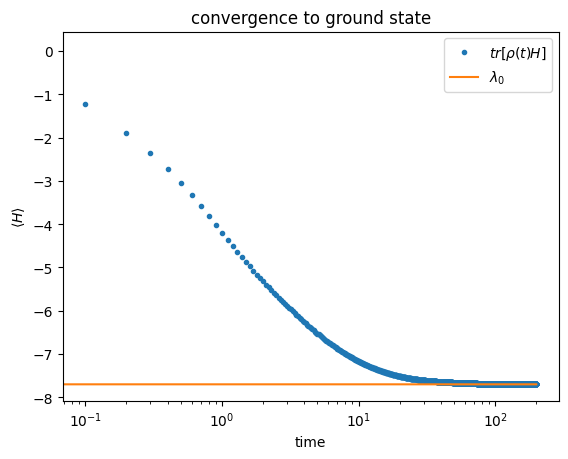

In [17]:
plt.semilogx(tau * np.arange(nsteps + 1), en_list, ".", label=r"$tr[\rho(t) H]$")
plt.semilogx(tau * np.arange(nsteps + 1), eigvals[0]*np.ones(nsteps + 1), label=r"$\lambda_0$")
plt.legend()
plt.xlabel("time")
plt.ylabel(r"$\langle H \rangle$")
plt.title("convergence to ground state")
plt.show()